# Earth-Moon System

This adds self consistent spin, tidal and dynamical equations of motion in the equilibrium tide model as outlined by Eggleton et. al (1998). See Lu et. al (in review) for specific details of the implementation. In this simple example we investigate the behavior of the Earth-Moon system

This is a much simplified version of a complex problem. The primary simplification made is only the Earth-Moon system itself is considered - of course, the effects of the Sun are highly significant, but not considered in this simple example. Therefore, many of the exact numeric results in this notebook are not precisely accurate - the goal of this example is to show that the qualitative behavior of the system is well-produced. For more in-depth explorations of the Earth-Moon system, please see, e.g., Ward (1975), Touma & Wisdom (1994) and Wisdom (2007), among others.

In [1]:
import rebound
import reboundx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

First, definition of the physical parameters we'll need. Parameters are taken from
https://nssdc.gsfc.nasa.gov/planetary/factsheet/moonfact.html. We are working in default REBOUND units: mass in units of solar masses, distance in units of AU, and time in units of $2 \pi$ years

In [2]:
m_earth = 3e-6
r_earth = 4.259e-5
k2_earth = 0.298
c_earth = 0.3308 # Dimensionless moment of inertia, normalized by MR^2

m_moon = 3.6943e-8
r_moon = 1.161e-5
k2_moon = 0.239
c_moon = 0.394
inc_moon = np.radians(5.14)
Omega_moon = np.radians(0)

First, the present-day orbital parameters of the Earth-Moon System

In [3]:
sim = rebound.Simulation()
ps = sim.particles

Earth = rebound.Particle(simulation = sim, m=m_earth, r=r_earth, hash="Earth")
sim.add(Earth)

Moon = rebound.Particle(simulation = sim, primary = ps["Earth"], m=m_moon, r=r_moon, 
                        a=0.002572, e=0.0549, inc = inc_moon, Omega = Omega_moon, hash="Moon")
sim.add(Moon)

Now, we add the extra parameters necessary to calculate the spin and tidal effects. Let's first set the Love number, moment of inertia, and spin vector. The positions of the spin axes are set to their present-day values

In [4]:
rebx = reboundx.Extras(sim)
ts = rebx.load_force("tides_spin")
rebx.add_force(ts)

ps["Earth"].params['k2'] = k2_earth
ps["Earth"].params['I'] = c_earth * m_earth * r_earth**2

spin_period_earth = (1 / 365.26) * 2 * np.pi # 1 day in default REBOUND units
spin_mag_earth = 2 * np.pi / spin_period_earth
obl_earth = np.radians(23.44)
ps["Earth"].params['Omega'] = [0., spin_mag_earth * np.sin(obl_earth), spin_mag_earth * np.cos(obl_earth)]

ps["Moon"].params['k2'] = k2_moon
ps["Moon"].params['I'] = c_moon * m_moon * r_moon**2

spin_period_moon = ps["Moon"].P # assume synchronous rotation
spin_mag_moon = 2 * np.pi / spin_period_moon
obl_moon = np.radians(1.54) # angle between ecliptic normal and moon's spin vector
ps["Moon"].params['Omega'] = [0., spin_mag_moon * np.sin(obl_moon), spin_mag_moon * np.cos(obl_moon)]

Finally, we can set the constant time lag $\tau$, which sets the rate of tidal dissipation. Often, tidal dissipation is also parametrized in terms of the tidal quality factor Q. These are simply related for the particular case of synchronized, circular orbits (see Section 2 of Lu et. al (2023) for more discussion), in which case

$Q^{-1} \sim 2 n \tau$

where $n$ is the mean motion of the moon around the Earth (for both the lunar and Earth Q)

In [5]:
Earth_Q = 280
Moon_Q = 37.5
ps["Earth"].params['tau'] = 1 / (2 * Earth_Q * ps["Moon"].n)
ps["Moon"].params['tau'] = 1 / (2 * Moon_Q * ps["Moon"].n)

Some bookkeeping before we begin integrating the system: choosing an integrator, moving to the CoM, and aligning the system to the invariant plane (which aligns the spins as well as the orbits of the bodies)

In [6]:
sim.integrator = "whfast"
sim.dt = ps["Moon"].P/10.1234567 # timestep is a fraction of the orbital period
sim.move_to_com() # Move to CoM

rot = rebound.Rotation.to_new_axes(newz=rebx.calculate_total_angular_momentum()) # Alignment to invariant plane
rebx.rotate_simulation(rot)

The next step is mandatory: to track the evolution of the spin axis, you MUST call the function `initialize_spin_ode`. Otherwise the spin axis will remain stationary and you won't see anything interesting! Call this function after all parameters have been set and all rotations and frame changes are complete.

In [7]:
rebx.initialize_spin_ode(ts)

Now, we integrate. We track the spin axis of the moon and Earth, as well as a few key orbital parameters.

Note that both spin axes have been tracked in the inertial reference frame, which we have aligned with the invariant plane of the system. It is often much more useful to calculate the spin vector relative to the body's orbit normal. In this case we care about the moon's orbit normal, which we find with `ps["Moon"].hvec`. Here we'll interpret the results in this frame.

In [8]:
%%time
Nout = 10000
tmax = 2e6 # REBOUND time units
times = np.linspace(0, tmax, Nout) 

lunar_a = np.zeros(Nout)
lunar_orbit_period = np.zeros(Nout)

lunar_sv_hat = np.zeros((Nout, 3))
lunar_spin_mag = np.zeros(Nout)
lunar_obliquity = np.zeros(Nout)
lunar_phase = np.zeros(Nout)

earth_sv = np.zeros((Nout, 3))

for i, t in enumerate(times):
    # Orbital Parameters
    lunar_a[i] = ps["Moon"].a
    lunar_orbit_period[i] = ps["Moon"].P
    
    # Lunar spin vector
    lunar_spin_axis_inv = ps["Moon"].params['Omega'] # Initially invarant frame
    
    lunar_orbit_normal = ps["Moon"].hvec
    rot_to_orbit_frame = rebound.Rotation.to_new_axes(newz=lunar_orbit_normal)
    lunar_spin_axis_orb = rot_to_orbit_frame * lunar_spin_axis_inv # Now in the Moon's orbit frame
    
    # We save the unit lunar spin vector
    lunar_sv_hat[i] = lunar_spin_axis_orb / np.linalg.norm(lunar_spin_axis_orb)
    
    # We can also interpret the spin axis in the more natural spherical coordinates
    mag, obliquity, phase = rebound.xyz_to_spherical(lunar_spin_axis_orb)
    
    lunar_spin_mag[i] = mag
    lunar_obliquity[i] = np.degrees(obliquity)
    lunar_phase[i] = np.degrees(phase)
    
    # Earth spin vector
    # We will only concern ourselves with the Earth's spin period, so we only track the magnitude
    # Since the magnitude of the spin vector is invariant across frames, no transformations necessary
    earth_sv[i] = ps["Earth"].params['Omega']
    
    sim.integrate(t)

CPU times: user 1min 33s, sys: 521 ms, total: 1min 33s
Wall time: 1min 34s


First, we verify the position of the lunar spin axis. The Moon's spin axis currently lies in an equilibrium configuration known as a "Cassini State" - in the frame aligned with the lunar orbit normal we have adopted, the spin axis will appear stationary. 

While the precise parameters initially chosen represent the Moon's present-day spin-axis configuration, since the effects of the Sun are not accounted for the equilibrium value is slightly different. However, this ultimately doesn't matter: another prediction (see Ward 1975) is the spin vector, if displaced, rapidly evolves towards this equilibrium state. Below a polar view evolution of the unit lunar spin axis is plotted:

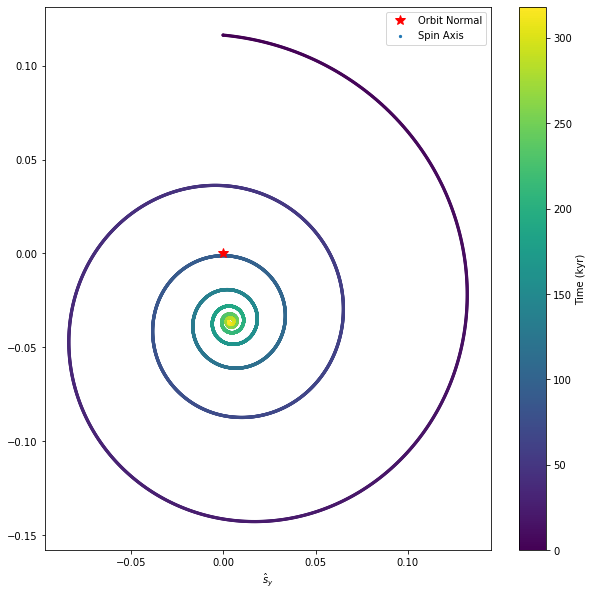

In [9]:
times_rescaled = times / (1000 * 2 * np.pi) # this converts from REBOUND time units to kyr
orbit_normal = np.array([0, 0, 1]) # Recall the z-axis is aligned with the orbit normal

plt.figure(figsize=(10,10))
plt.scatter(lunar_sv_hat[:,0], lunar_sv_hat[:,1], s=5, label = 'Spin Axis', c = times_rescaled)


plt.plot(orbit_normal[0], orbit_normal[1], marker='*', label='Orbit Normal', color ='red', markersize=10, ls = ' ')
plt.xlabel(r'$\hat{s}_x$')
plt.xlabel(r'$\hat{s}_y$')
plt.legend()
plt.colorbar(label="Time (kyr)")

We see that the spin axis rapidly evolves towards Cassini State 2, at which point it appears stationary. 

We can further verify by plotting a few other representative quantities. Other predictions include:

- The gradual increase of the lunar semimajor axis
- A near-match between the lunar spin and orbital periods (characteristic of tidal locking)
- A slow spin-down of the Earth's rotation
- The lunar obliquity (the angle between its spin axis and orbit normal) rapidly evolving to a small value, and thereafter remaining constant.

Text(0, 0.5, 'Lunar Obliquity $\\theta [^\\circ]$')

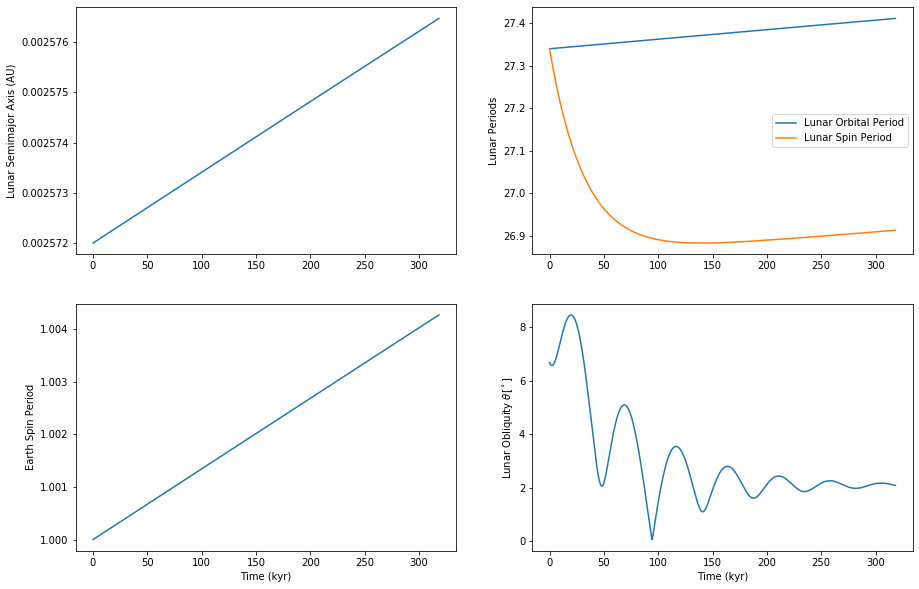

In [13]:
# Rescale orbital periods to days
lunar_orbit_period_days = lunar_orbit_period / (2 * np.pi) * 365.26

lunar_spin_period = 2 * np.pi / lunar_spin_mag / (2 * np.pi) * 365.26
earth_spin_period = (2 * np.pi / np.linalg.norm(earth_sv, axis=1)) / (2 * np.pi) * 365.26

fig, ax = plt.subplots(2, 2,figsize=(15,10))
ax = ax.ravel()

ax[0].plot(times_rescaled, lunar_a)
ax[0].set_ylabel('Lunar Semimajor Axis (AU)')

ax[1].plot(times_rescaled, lunar_orbit_period_days, label = 'Lunar Orbital Period')
ax[1].plot(times_rescaled, lunar_spin_period, label = 'Lunar Spin Period')
ax[1].set_ylabel('Lunar Periods')
ax[1].legend()

ax[2].plot(times_rescaled, earth_spin_period)
ax[2].set_ylabel('Earth Spin Period')
ax[2].set_xlabel('Time (kyr)')

ax[3].plot(times_rescaled, lunar_obliquity)
ax[3].set_xlabel('Time (kyr)')
ax[3].set_ylabel(r'Lunar Obliquity $\theta [^\circ]$')

We see that the qualitative expected behavior is seen in all cases!